### Dataset Downloading

In [ ]:
!pip install wldhx.yadisk-direct

In [ ]:
!curl -L $(yadisk-direct https://disk.yandex.ru/d/-4g-l44mqslQXg) -o data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  194M  100  194M    0     0  44.6M      0  0:00:04  0:00:04 --:--:-- 68.6M


In [ ]:
!unzip data.zip >> /dev/null

### Dataset Preparation

In [ ]:
import os
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class MultiClassBUSIDataset(Dataset):
    """
    Multi-class version of BUSI Dataset:
    - Class 0: Background
    - Class 1: Benign
    - Class 2: Malignant

    Expects a directory structure:
    root_dir/
        benign/
            benign_1.png
            benign_1_mask.png
            ...
        malignant/
            malignant_1.png
            malignant_1_mask.png
            ...
        normal/
            normal_1.png
            normal_1_mask.png
            ...
    """
    def __init__(self, root_dir, image_size=(256, 256), transform=None, samples=None,
                 include_normal=True):
        """
        :param image_size: desired HxW for resizing
        :param transform: any additional torchvision transform
        :param samples: optional list of (image_path, mask_path, class_id) tuples. If None, scans automatically.
        :param include_normal: whether to include normal cases (no lesions)
        """
        self.root_dir = root_dir
        self.image_size = image_size
        self.transform = transform
        self.include_normal = include_normal

        # Class mapping
        self.class_to_idx = {
            'background': 0,
            'benign': 1,
            'malignant': 2
        }

        if samples is not None:
            # If we already have a subset for train/val
            self.samples = samples
        else:
            self.samples = self._scan_dataset()

    def _scan_dataset(self):
        samples = []

        # Determine which subfolders to scan
        if self.include_normal:
            subfolders = ["benign", "malignant", "normal"]
        else:
            subfolders = ["benign", "malignant"]

        for sf in subfolders:
            folder_path = os.path.join(self.root_dir, sf)
            # find all *mask.png
            mask_paths = glob.glob(os.path.join(folder_path, "*_mask.png"))
            for mp in mask_paths:
                # corresponding image path is mp.replace("_mask", "")
                img_path = mp.replace("_mask", "")
                if os.path.exists(img_path):
                    # Determine class from folder name
                    if sf == "normal":
                        class_id = 0  # Normal cases have no lesions, just background
                    elif sf == "benign":
                        class_id = 1  # Benign
                    elif sf == "malignant":
                        class_id = 2  # Malignant

                    samples.append((img_path, mp, class_id))

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path, class_id = self.samples[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)
        image = image.astype(np.float32) / 255.0

        binary_mask = (mask > 127).astype(np.uint8)

        if class_id == 0:  # Normal case - all background
            multi_class_mask = np.zeros_like(binary_mask)
        else:  # Benign or Malignant
            multi_class_mask = binary_mask * class_id

        if self.transform is not None:
            # Here you would apply any data augmentation
            pass

        image_tensor = torch.from_numpy(image).unsqueeze(0)  # [1, H, W]

        mask_tensor = torch.from_numpy(multi_class_mask).long()  # [H, W]

        return image_tensor, mask_tensor

In [ ]:
def create_train_val_datasets(root_dir, val_ratio=0.2, image_size=(256, 256), include_normal=True, stratify=True):
    """
    Splits the dataset into train and validation sets with optional stratification by class.
    Returns two MultiClassBUSIDataset objects.

    Args:
        root_dir: Base directory containing the dataset folders
        val_ratio: Percentage of data to use for validation
        image_size: Tuple of (height, width) for resizing
        include_normal: Whether to include normal cases
        stratify: Whether to maintain class balance in train/val splits

    Returns:
        train_dataset, val_dataset
    """
    import os
    import glob
    import random
    from collections import defaultdict

    if include_normal:
        subfolders = ["benign", "malignant", "normal"]
    else:
        subfolders = ["benign", "malignant"]

    all_samples = []
    samples_by_class = defaultdict(list)

    for sf in subfolders:
        folder_path = os.path.join(root_dir, sf)
        mask_paths = glob.glob(os.path.join(folder_path, "*_mask.png"))

        for mp in mask_paths:
            img_path = mp.replace("_mask", "")
            if os.path.exists(img_path):
                if sf == "normal":
                    class_id = 0
                elif sf == "benign":
                    class_id = 1
                elif sf == "malignant":
                    class_id = 2

                sample = (img_path, mp, class_id)
                all_samples.append(sample)
                samples_by_class[class_id].append(sample)

    train_samples = []
    val_samples = []

    if stratify:
        for class_id, samples in samples_by_class.items():
            random.shuffle(samples)
            val_count = int(len(samples) * val_ratio)

            val_samples.extend(samples[:val_count])
            train_samples.extend(samples[val_count:])

            print(f"Class {class_id}: {len(samples)} total, {len(samples) - val_count} train, {val_count} validation")
    else:
        random.shuffle(all_samples)
        val_count = int(len(all_samples) * val_ratio)
        val_samples = all_samples[:val_count]
        train_samples = all_samples[val_count:]

    train_dataset = MultiClassBUSIDataset(
        root_dir,
        image_size=image_size,
        samples=train_samples,
        include_normal=include_normal
    )

    val_dataset = MultiClassBUSIDataset(
        root_dir,
        image_size=image_size,
        samples=val_samples,
        include_normal=include_normal
    )

    print(f"Total: {len(all_samples)} samples")
    print(f"Train: {len(train_samples)} samples")
    print(f"Validation: {len(val_samples)} samples")

    return train_dataset, val_dataset

### Creating the model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, in_channels, gate_channels, inter_channels):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(gate_channels, inter_channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(inter_channels)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(inter_channels)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(inter_channels, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class ImprovedUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, init_features=32):
        super(ImprovedUNet, self).__init__()

        features = init_features
        self.encoder1 = self._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = self._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = self._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._block(features * 2, features, name="dec1")

        self.attention4 = AttentionBlock(features * 8, features * 8, features * 8)
        self.attention3 = AttentionBlock(features * 4, features * 4, features * 4)
        self.attention2 = AttentionBlock(features * 2, features * 2, features * 2)

        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)

    def _block(self, in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        enc4 = self.attention4(enc4, dec4)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        enc3 = self.attention3(enc3, dec3)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        enc2 = self.attention2(enc2, dec2)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.conv(dec1)

In [ ]:
train_dataset, val_dataset = create_train_val_datasets(
    root_dir='/content/content/kaggle_dataset_3/train',
    val_ratio=0.2,
    image_size=(256, 256),
    include_normal=True,  # Set to False if you don't want normal cases
    stratify=True         # Maintain class distribution in splits
)

# Create data loaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

Class 1: 355 total, 284 train, 71 validation
Class 2: 167 total, 134 train, 33 validation
Class 0: 102 total, 82 train, 20 validation
Total: 624 samples
Train: 500 samples
Validation: 124 samples


### Training the model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import wandb
import numpy as np
from torchvision.utils import make_grid
import random
from IPython.display import clear_output, display
import time
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from sklearn.metrics import precision_score, recall_score, f1_score

# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, weight=None, smooth=1e-7):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.weight = weight

    def forward(self, inputs, targets):
        num_classes = inputs.shape[1]
        targets_onehot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()
        inputs = F.softmax(inputs, dim=1)

        intersection = (inputs * targets_onehot).sum(dim=(2, 3))
        sum_inputs = inputs.sum(dim=(2, 3))
        sum_targets = targets_onehot.sum(dim=(2, 3))

        dice = (2. * intersection + self.smooth) / (sum_inputs + sum_targets + self.smooth)
        if self.weight is not None:
            dice = dice * self.weight.to(inputs.device)
        return 1 - dice.mean()

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

# Boundary Loss
class BoundaryLoss(nn.Module):
    def __init__(self):
        super(BoundaryLoss, self).__init__()
        self.kernel = torch.tensor([[[[0, -1, 0], [-1, 4, -1], [0, -1, 0]]]], dtype=torch.float32)

    def forward(self, pred, target):
        self.kernel = self.kernel.to(pred.device)
        target_onehot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
        pred_boundary = self._compute_boundary(pred)
        target_boundary = self._compute_boundary(target_onehot)
        return F.l1_loss(pred_boundary, target_boundary)

    def _compute_boundary(self, x):
        if x.dim() == 4:
            x = x.mean(dim=1, keepdim=True)
        elif x.dim() == 3:
            x = x.unsqueeze(1)
        return F.conv2d(x, weight=self.kernel, padding=1)

# Enhanced Training Function
def train_multiclass_unet_improved(model, train_loader, val_loader, num_epochs=100, learning_rate=3e-4,
                                  class_weights=None, device=None, use_wandb=False, interactive=True,
                                  ce_weight=0.4, dice_weight=0.4, focal_weight=0.1, boundary_weight=0.1):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = model.to(device)

    # Loss Functions
    if class_weights is not None:
        class_weights = class_weights.to(device)
        criterion_ce = nn.CrossEntropyLoss(weight=class_weights)
        criterion_dice = DiceLoss(weight=class_weights)
        criterion_focal = FocalLoss(alpha=class_weights)
    else:
        criterion_ce = nn.CrossEntropyLoss()
        criterion_dice = DiceLoss()
        criterion_focal = FocalLoss()

    criterion_boundary = BoundaryLoss()

    # Optimizer and Scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    # Mixed Precision Training
    use_amp = device.type == 'cuda'
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    # Visualization Setup
    if interactive:
        plt.ion()
        live_fig, live_axs = plt.subplots(4, 3, figsize=(18, 16))
        live_fig.tight_layout(pad=3.0)

    train_losses = []
    val_losses = []
    dice_scores = {
        "dice_bg": [],
        "dice_benign": [],
        "dice_malignant": []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        train_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast(enabled=use_amp):
                output = model(data)
                ce_loss = criterion_ce(output, target)
                dice_loss = criterion_dice(output, target)
                focal_loss = criterion_focal(output, target)
                boundary_loss = criterion_boundary(output, target)
                loss = (ce_weight * ce_loss + dice_weight * dice_loss +
                        focal_weight * focal_loss + boundary_weight * boundary_loss)

            if use_amp:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0
        val_metrics = {"dice_bg": 0, "dice_benign": 0, "dice_malignant": 0}

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                ce_loss = criterion_ce(output, target)
                dice_loss = criterion_dice(output, target)
                focal_loss = criterion_focal(output, target)
                boundary_loss = criterion_boundary(output, target)
                loss = (ce_weight * ce_loss + dice_weight * dice_loss +
                        focal_weight * focal_loss + boundary_weight * boundary_loss)
                val_loss += loss.item()

                preds = torch.argmax(output, dim=1)

                for class_idx, class_name in enumerate(['bg', 'benign', 'malignant']):
                    pred_class = (preds == class_idx).float()
                    target_class = (target == class_idx).float()
                    intersection = (pred_class * target_class).sum().item()
                    union = pred_class.sum().item() + target_class.sum().item()

                    if union > 0:
                        dice = (2 * intersection) / (union + 1e-7)
                        val_metrics[f"dice_{class_name}"] += dice

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        for metric in val_metrics:
            val_metrics[metric] /= len(val_loader)
            dice_scores[metric].append(val_metrics[metric])

        scheduler.step()

        # Print Dice Scores
        print(f"Epoch {epoch + 1} - Dice Scores: BG: {val_metrics['dice_bg']:.4f}, Benign: {val_metrics['dice_benign']:.4f}, Malignant: {val_metrics['dice_malignant']:.4f}")

        # Visualization
        if interactive and (epoch % 5 == 0 or epoch == num_epochs - 1):
            clear_output(wait=True)
            live_axs[0, 0].clear()
            live_axs[0, 0].plot(range(len(train_losses)), train_losses, 'b-', label='Train Loss')
            live_axs[0, 0].plot(range(len(val_losses)), val_losses, 'r-', label='Val Loss')
            live_axs[0, 0].legend()
            live_axs[0, 0].set_title('Training & Validation Loss')
            live_axs[0, 0].set_xlabel('Epochs')
            live_axs[0, 0].set_ylabel('Loss')
            live_axs[0, 0].grid(True)

            live_axs[0, 1].clear()
            for dice_type, color, marker in zip(
                dice_scores.keys(),
                ['g-', 'b-', 'r-'],
                ['o', 's', '^']
            ):
                class_name = dice_type.split('_')[1]
                live_axs[0, 1].plot(
                    range(len(dice_scores[dice_type])),
                    dice_scores[dice_type],
                    color+marker,
                    label=f'Dice {class_name.capitalize()}'
                )
            live_axs[0, 1].legend()
            live_axs[0, 1].set_title('Dice Coefficients')
            live_axs[0, 1].set_xlabel('Epochs')
            live_axs[0, 1].set_ylabel('Dice Score')
            live_axs[0, 1].grid(True)

            live_fig.suptitle(f'Training Progress - Epoch {epoch}/{num_epochs}', fontsize=16)
            live_fig.tight_layout(pad=3.0, rect=[0, 0, 1, 0.95])
            display(live_fig)
            plt.pause(0.1)

    if interactive:
        plt.ioff()
        plt.close(live_fig)

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'dice_scores': dice_scores
    }

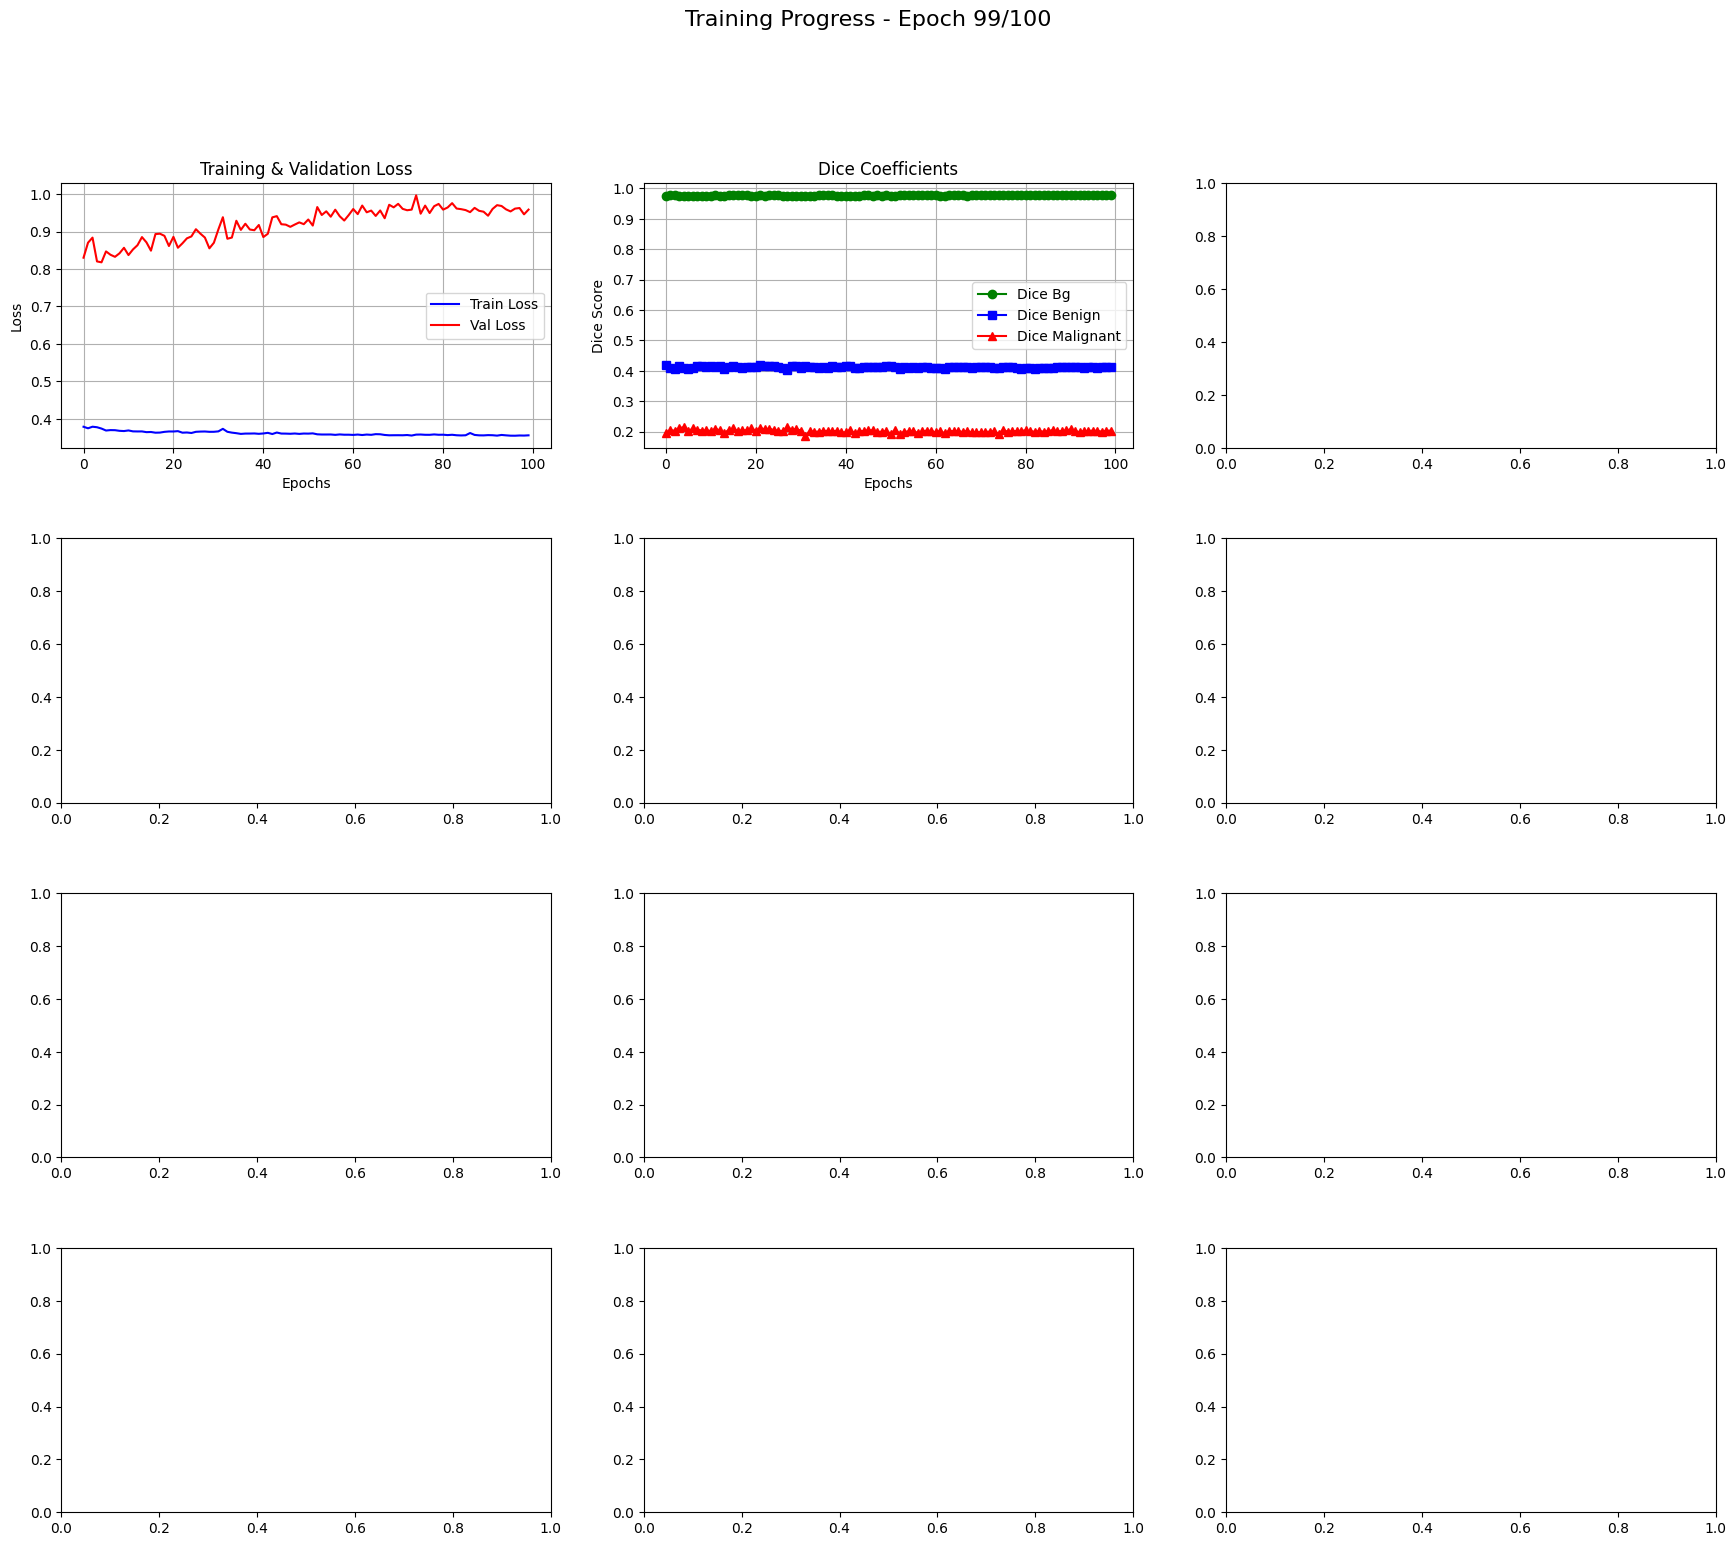

In [ ]:
# Assuming ImprovedUNet is already defined
model = ImprovedUNet(in_channels=1, out_channels=3)

import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from torchvision import transforms
from torch.utils.data import DataLoader

# Initialize WandB
wandb.login()
wandb.init(project="breast-ultrasound-segmentation1", name="ImprovedUNet_Training1")

# Assuming ImprovedUNet and dataset are already defined
model = ImprovedUNet(in_channels=1, out_channels=3).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(size=(256, 256))
])

# Assuming train_loader and val_loader are defined
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # Log metrics to WandB
    wandb.log({
        "Epoch": epoch + 1,
        "Train Loss": train_loss / len(train_loader),
        "Validation Loss": val_loss
    })

    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

wandb.finish()


# Train the model
training_history = train_multiclass_unet_improved(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100,
    learning_rate=3e-4,
    class_weights=torch.tensor([0.1, 1.0, 1.0]),
    ce_weight=0.3,
    dice_weight=0.5,
    focal_weight=0.1,
    boundary_weight=0.1,
    use_wandb=False
)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os


def visualize_multiclass_prediction(model, data_loader, num_samples=4, save_dir=None):
    """
    Visualizes model predictions alongside input images and ground truth masks for multi-class segmentation.

    Args:
        model: The trained UNet model
        data_loader: DataLoader containing validation or test data
        num_samples: Number of samples to visualize
        save_dir: Directory to save the visualizations (if None, just displays them)
    """
    model.eval()

    colors = np.array([[0, 0, 0],       # Background - Black
                      [0, 0.7, 1],      # Benign - Blue
                      [1, 0.3, 0.3]])   # Malignant - Red

    segmentation_cmap = ListedColormap(colors)

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    samples_processed = 0

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)

            logits = model(images)
            preds = torch.argmax(logits, dim=1)

            batch_size = images.shape[0]
            for i in range(batch_size):
                if samples_processed >= num_samples:
                    break

                img = images[i].detach().cpu().numpy().squeeze()
                mask = masks[i].detach().cpu().numpy()
                pred = preds[i].detach().cpu().numpy()

                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(img, cmap='gray')
                axes[0].set_title('Input Ultrasound')
                axes[0].axis('off')

                axes[1].imshow(mask, cmap=segmentation_cmap, vmin=0, vmax=2)
                axes[1].set_title('Ground Truth')
                axes[1].axis('off')

                axes[2].imshow(pred, cmap=segmentation_cmap, vmin=0, vmax=2)
                axes[2].set_title('Prediction')
                axes[2].axis('off')

                patches = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(3)]
                labels = ['Background', 'Benign', 'Malignant']
                fig.legend(patches, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

                # Calculate class-wise Dice scores
                dice_scores = []
                for class_idx in range(3):
                    pred_class = (pred == class_idx).astype(np.float32)
                    mask_class = (mask == class_idx).astype(np.float32)

                    intersection = np.sum(pred_class * mask_class)
                    union = np.sum(pred_class) + np.sum(mask_class)

                    dice = (2. * intersection + 1e-7) / (union + 1e-7)
                    dice_scores.append(dice)

                fig.suptitle(f'Dice Scores - Background: {dice_scores[0]:.3f}, '
                            f'Benign: {dice_scores[1]:.3f}, Malignant: {dice_scores[2]:.3f}')

                plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Make room for legend

                if save_dir is not None:
                    plt.savefig(os.path.join(save_dir, f'sample_{samples_processed}.png'),
                                bbox_inches='tight', dpi=150)
                    plt.close()
                else:
                    plt.show()

                samples_processed += 1

            if samples_processed >= num_samples:
                break

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2) # shuffle to visualize different images

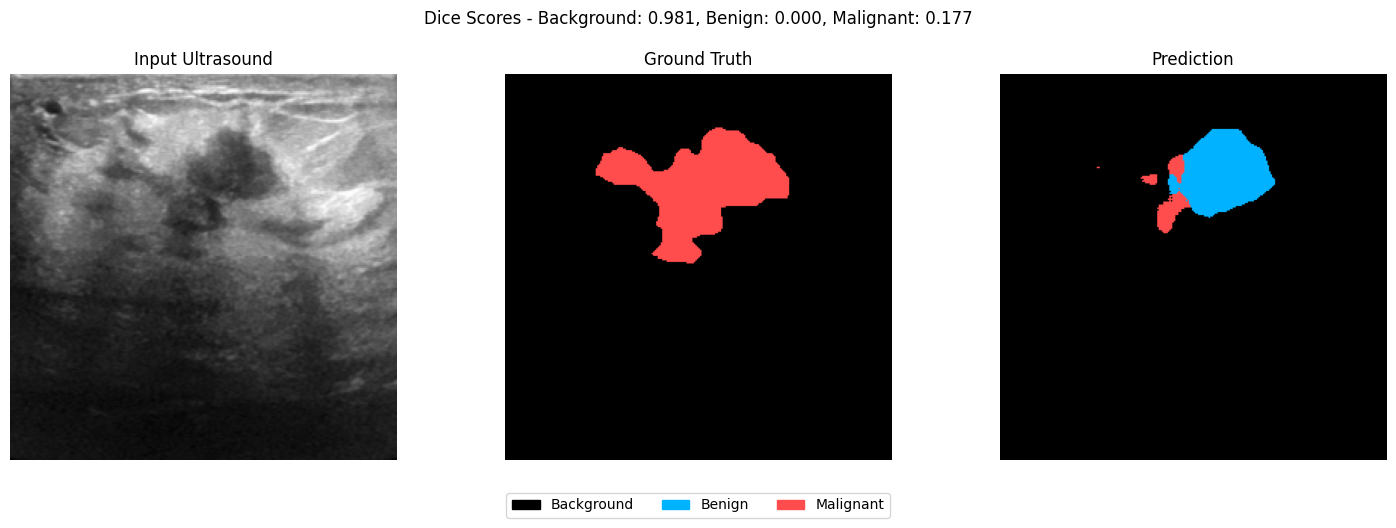

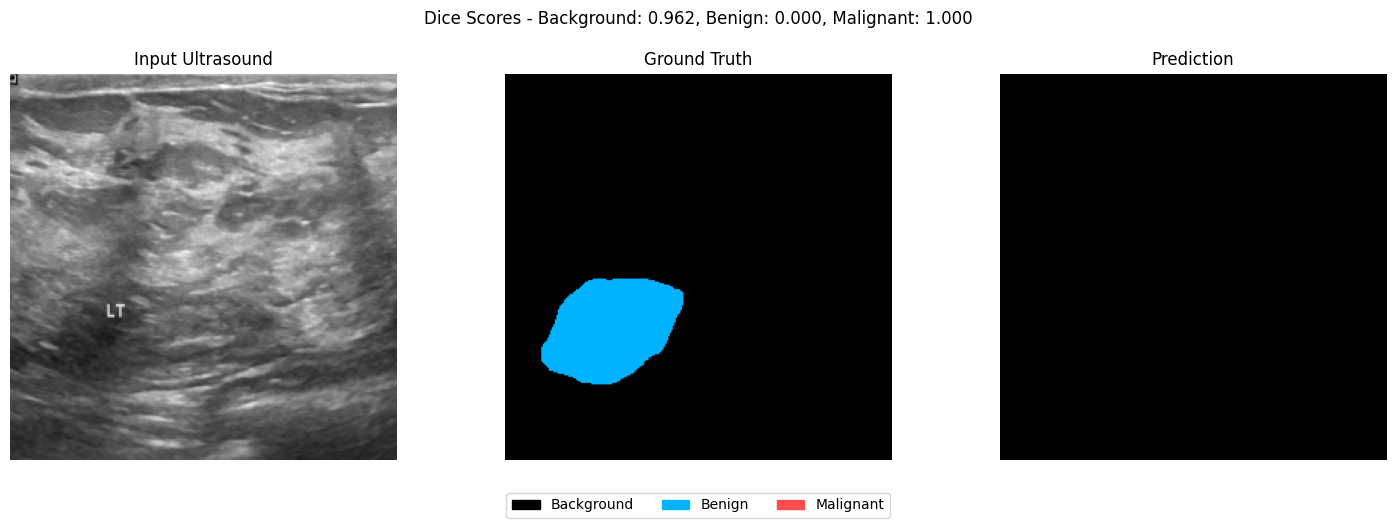

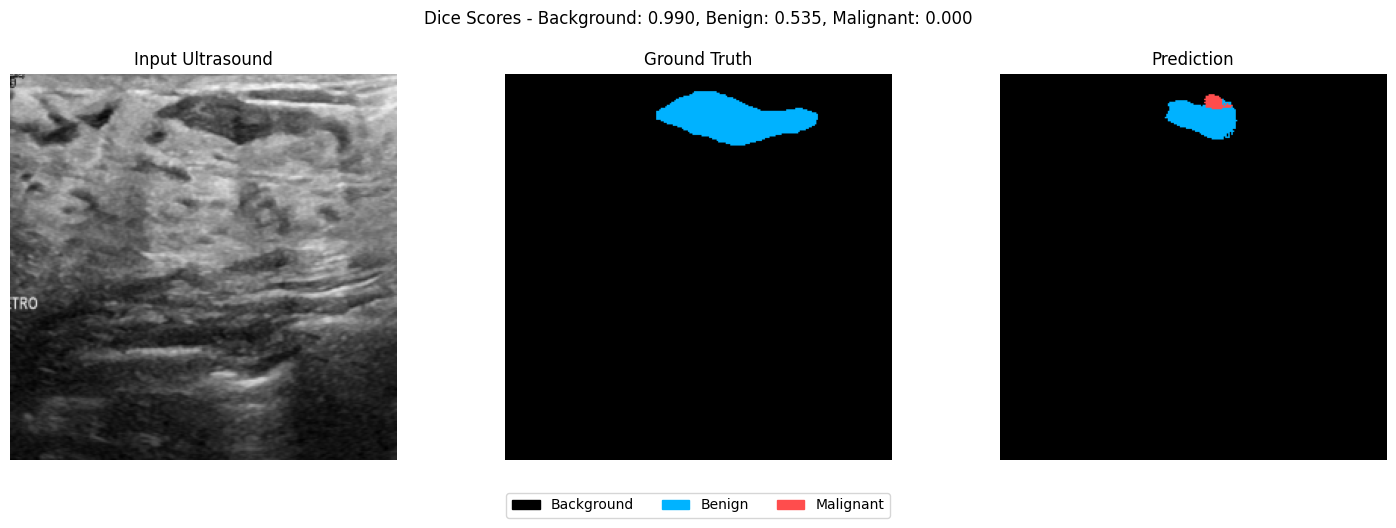

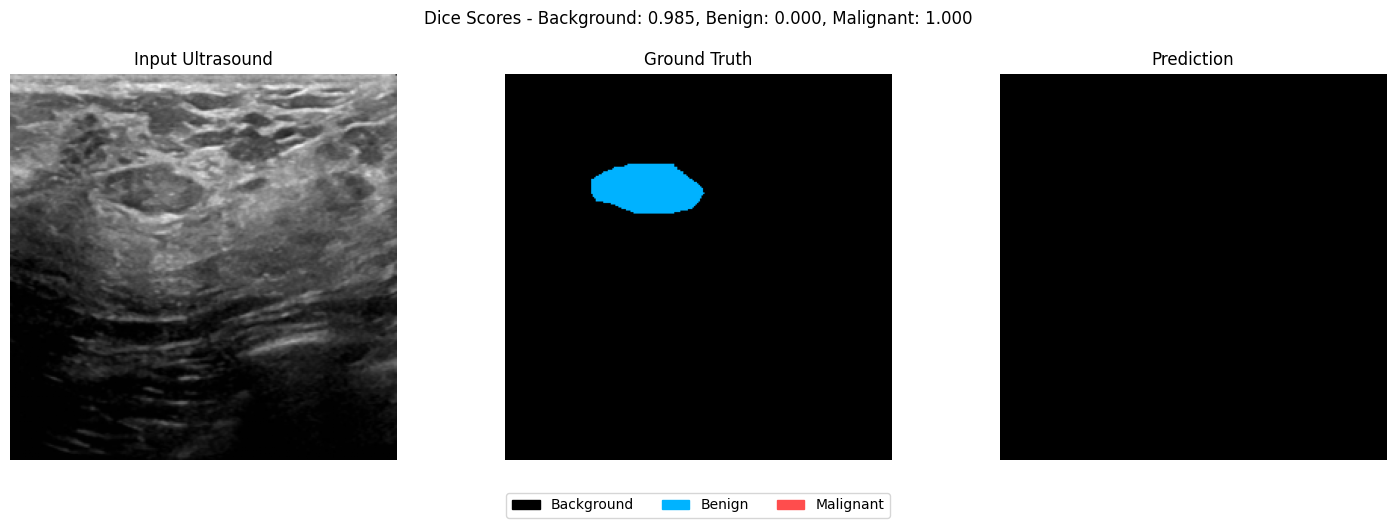

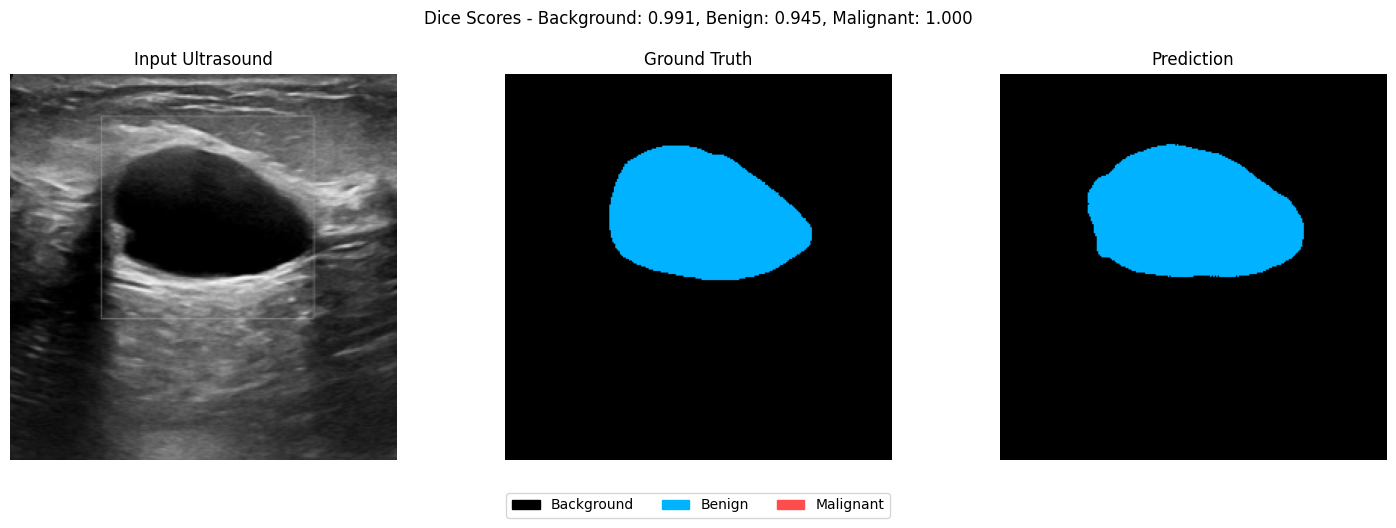

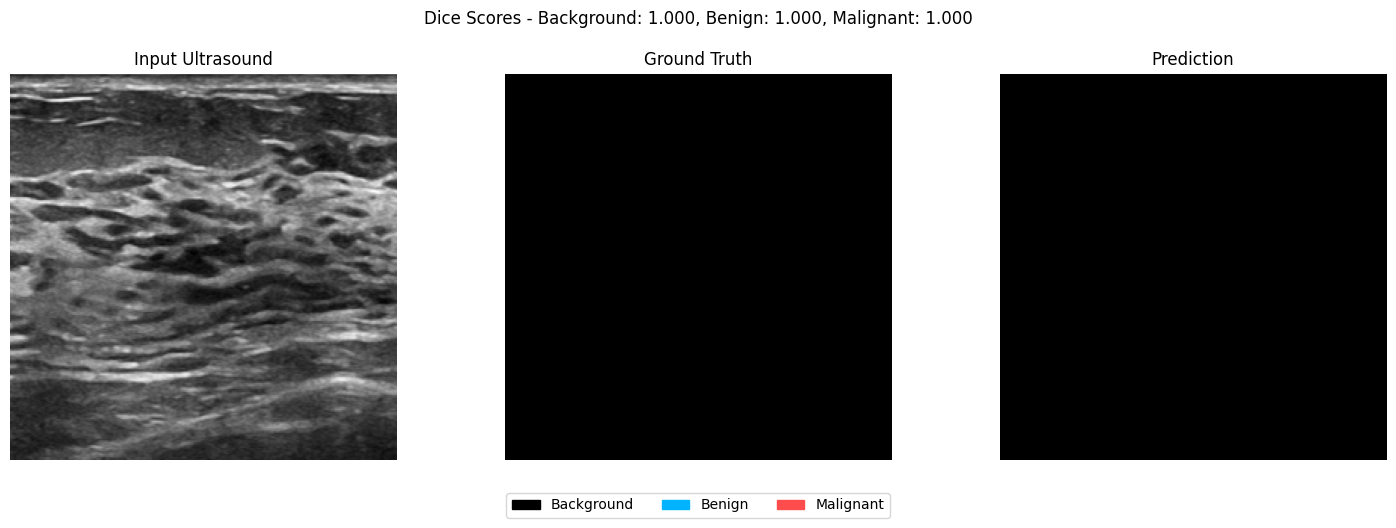

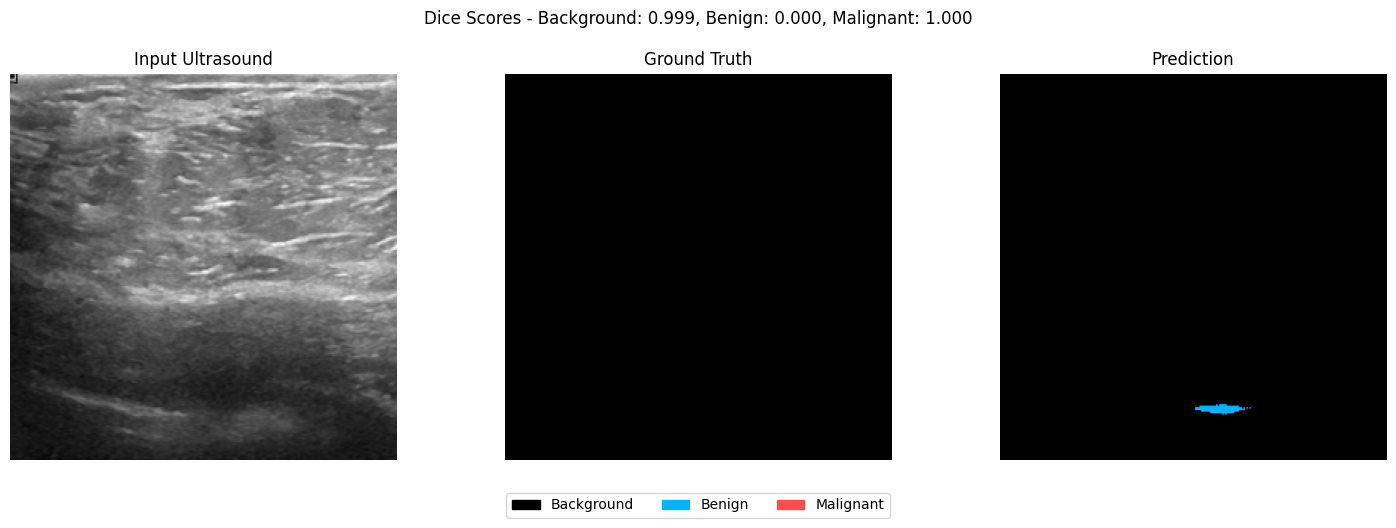

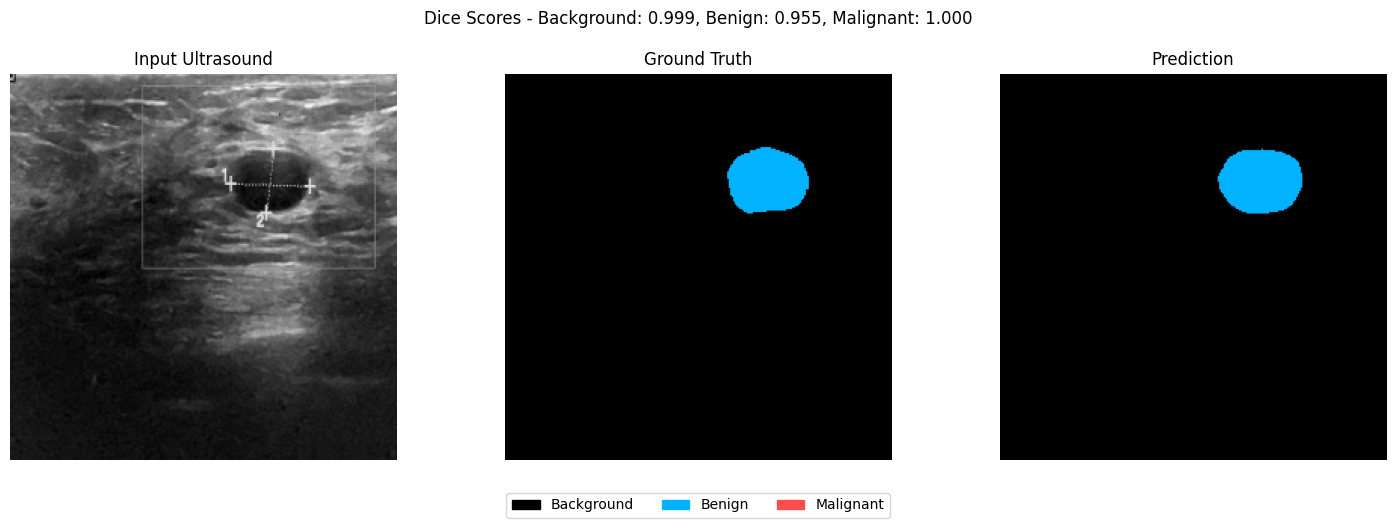

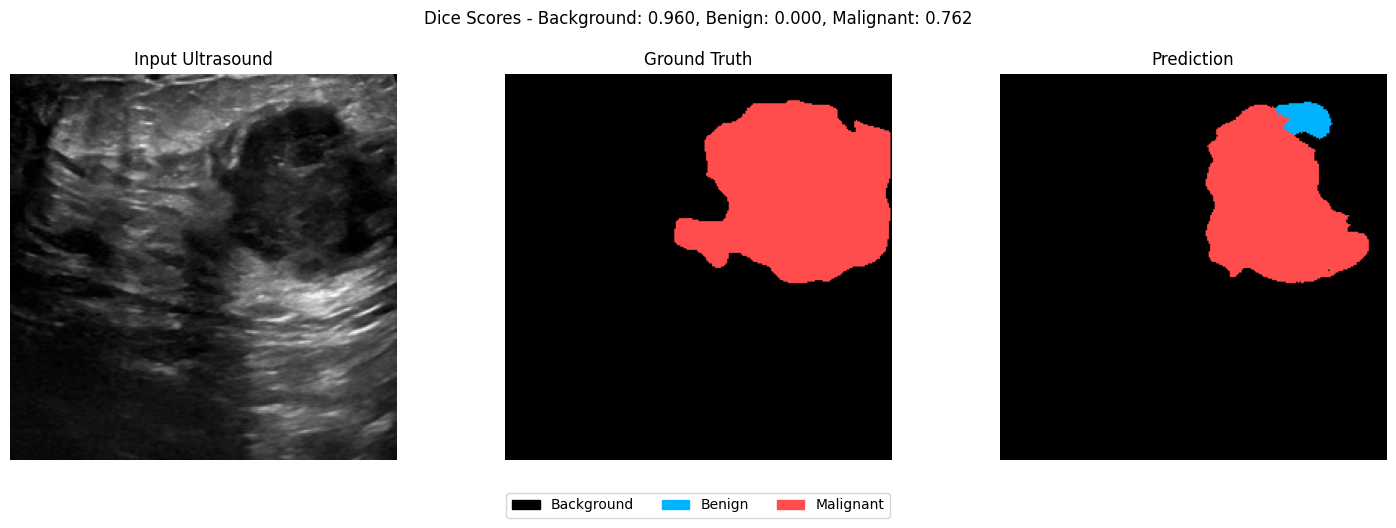

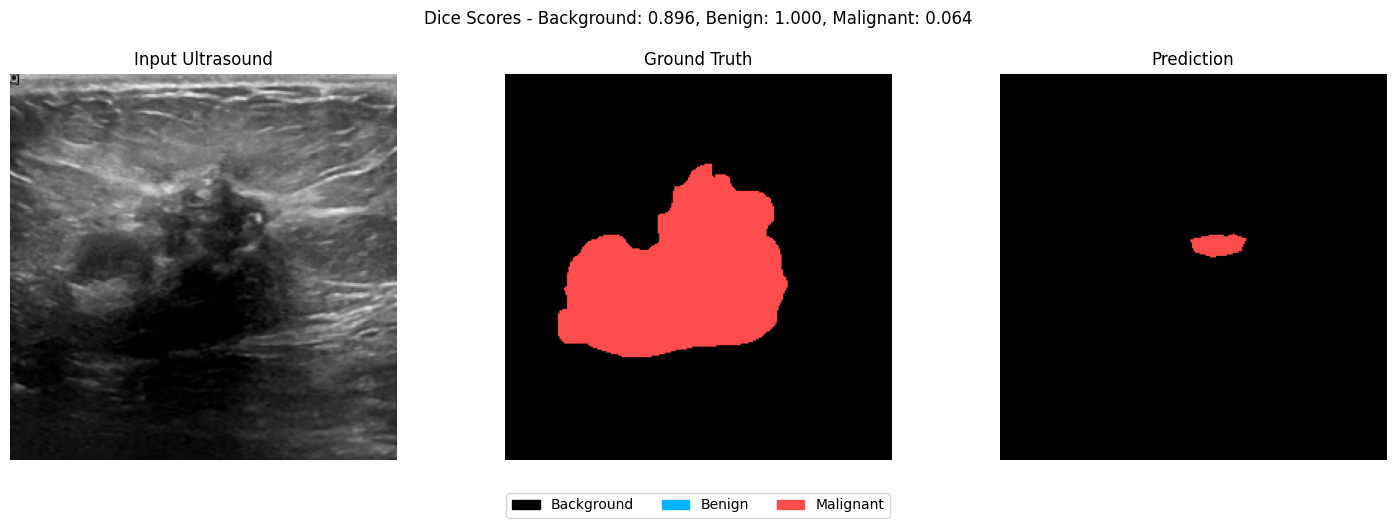

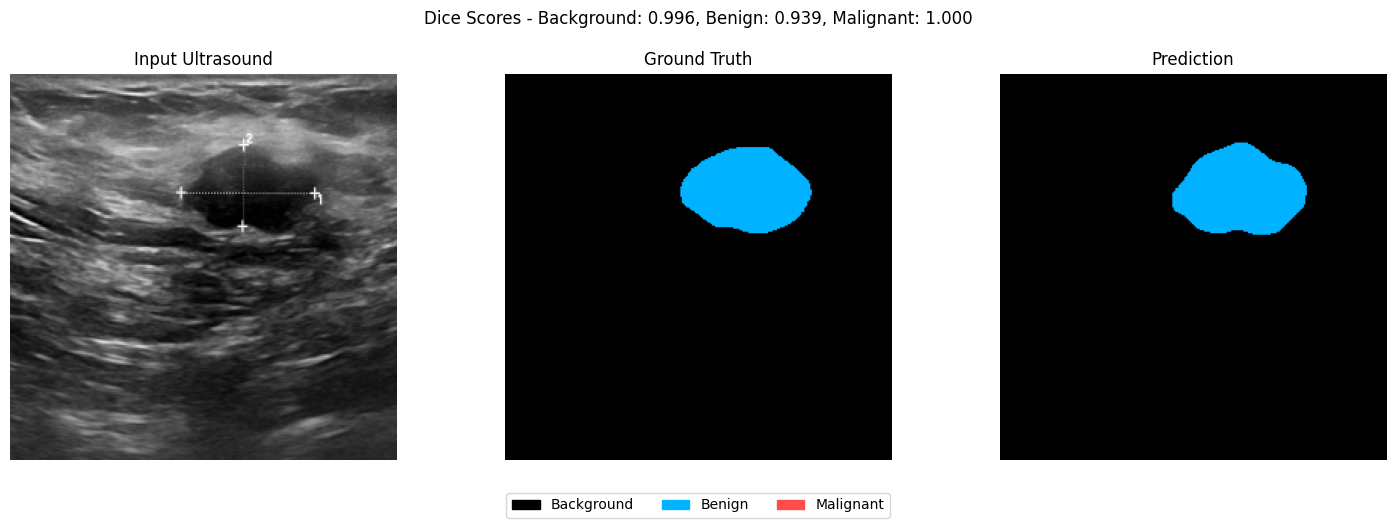

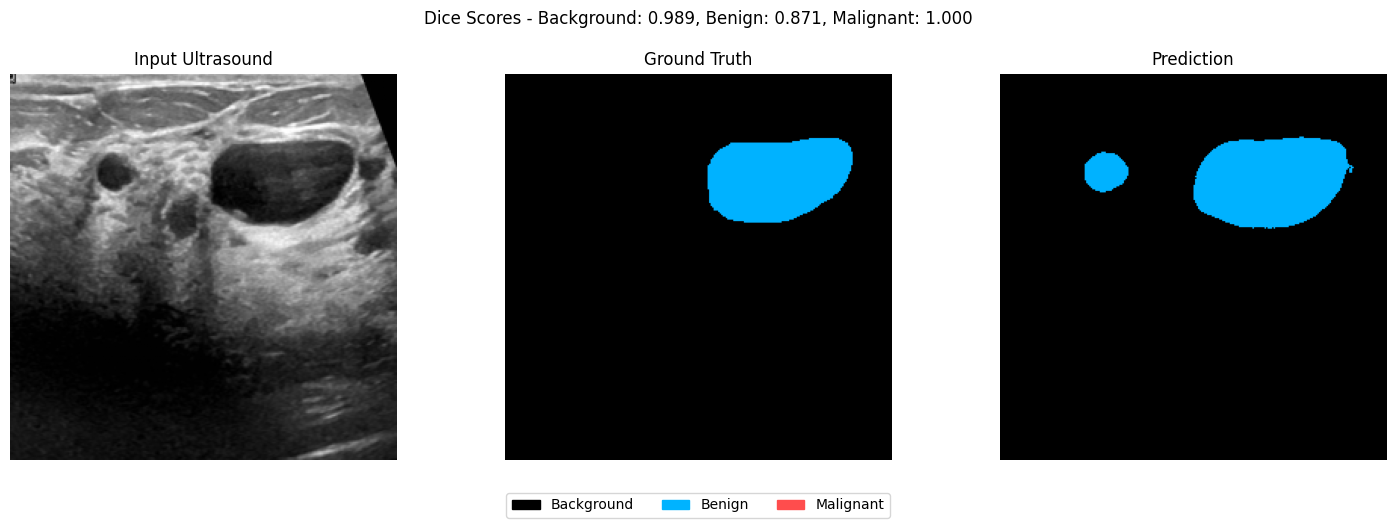

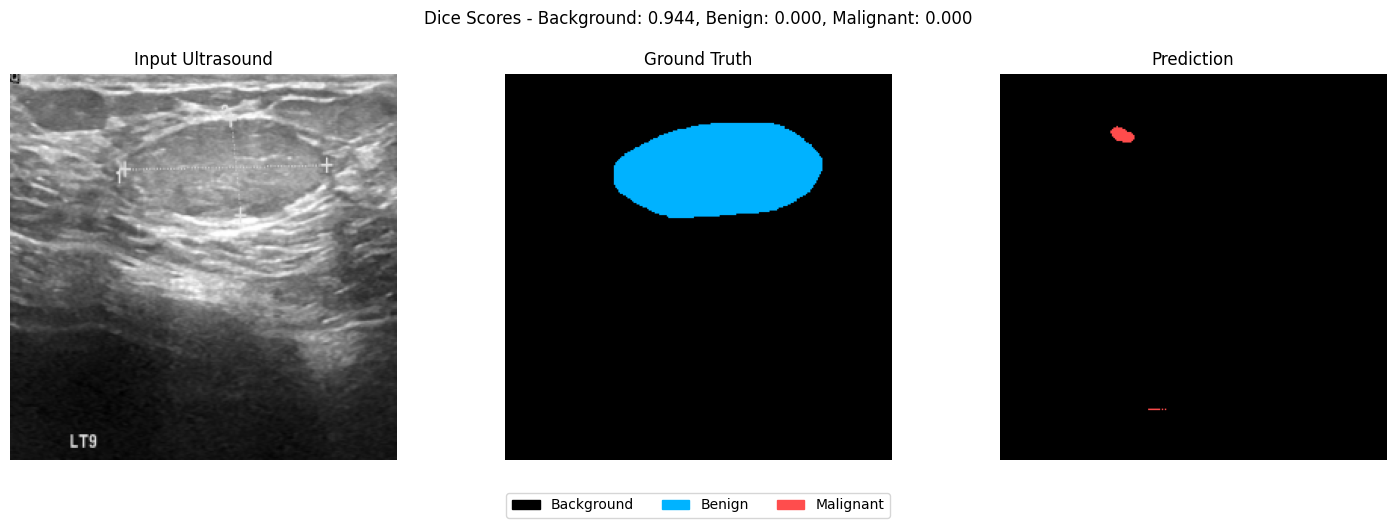

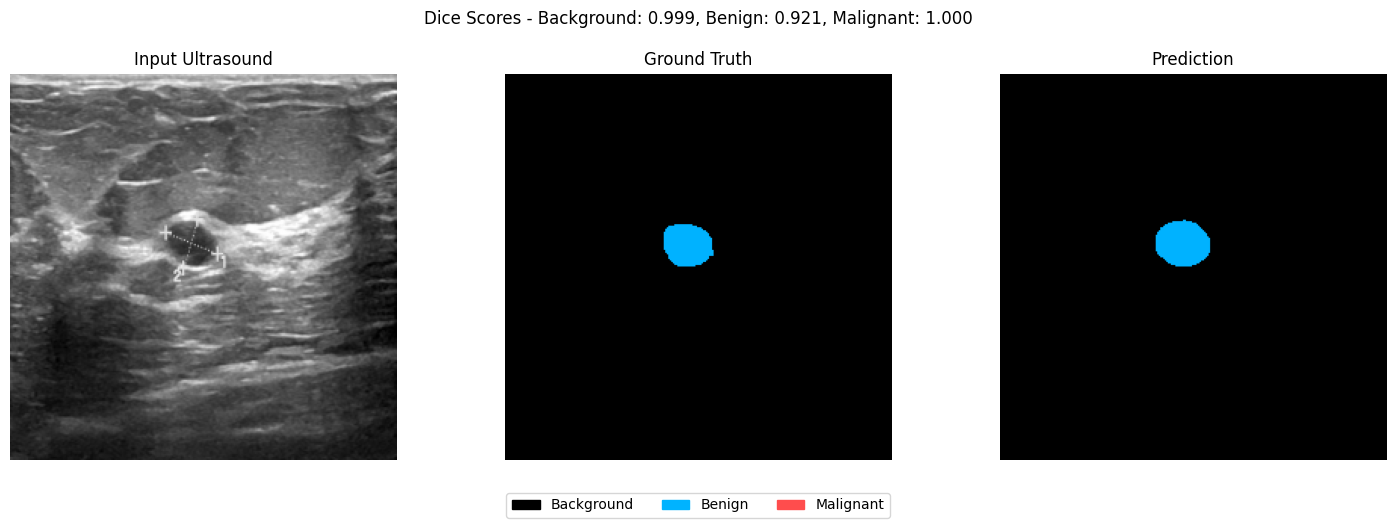

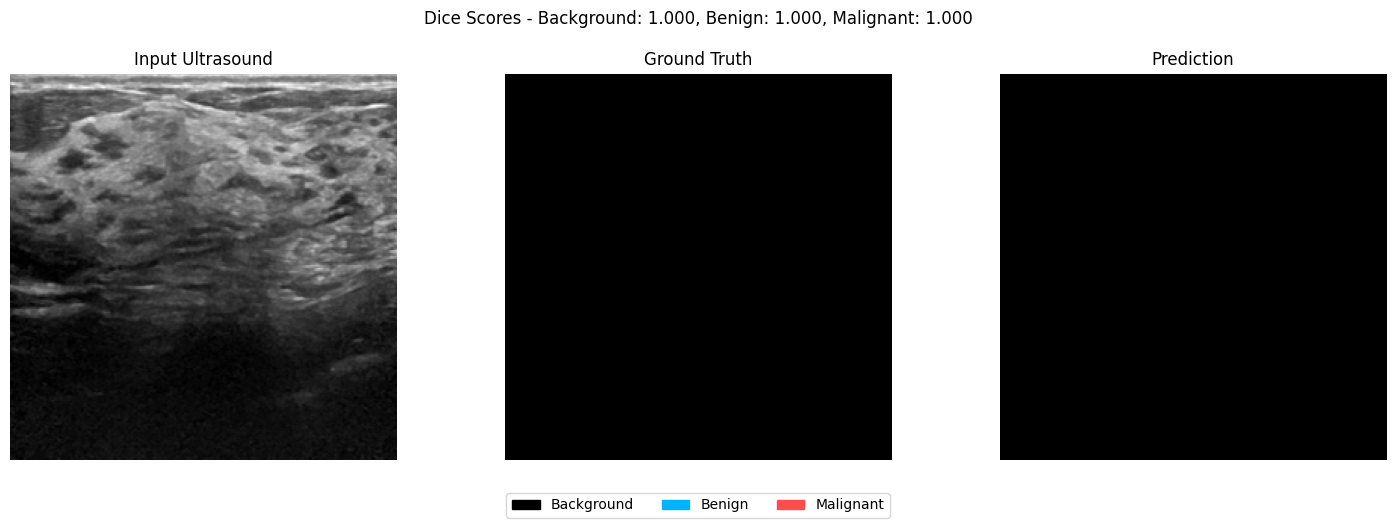

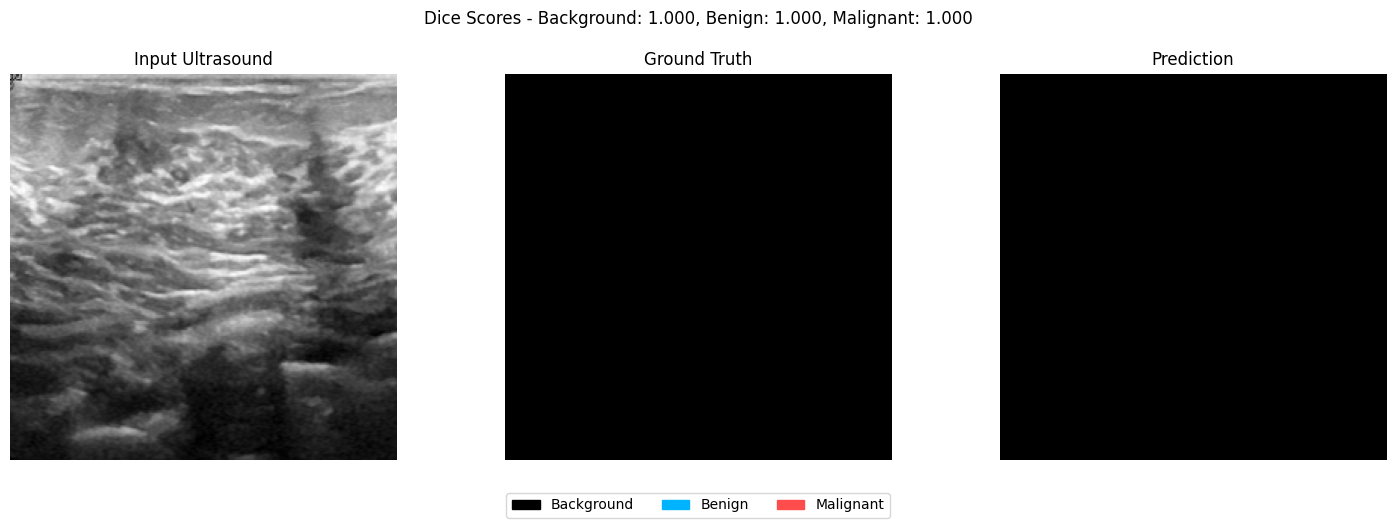

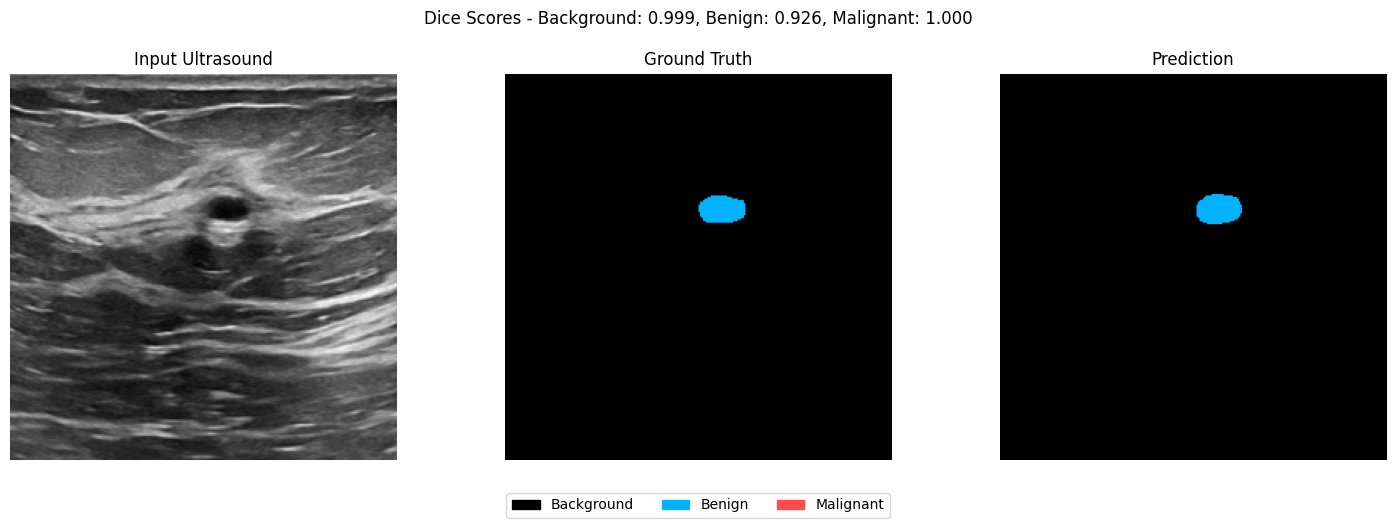

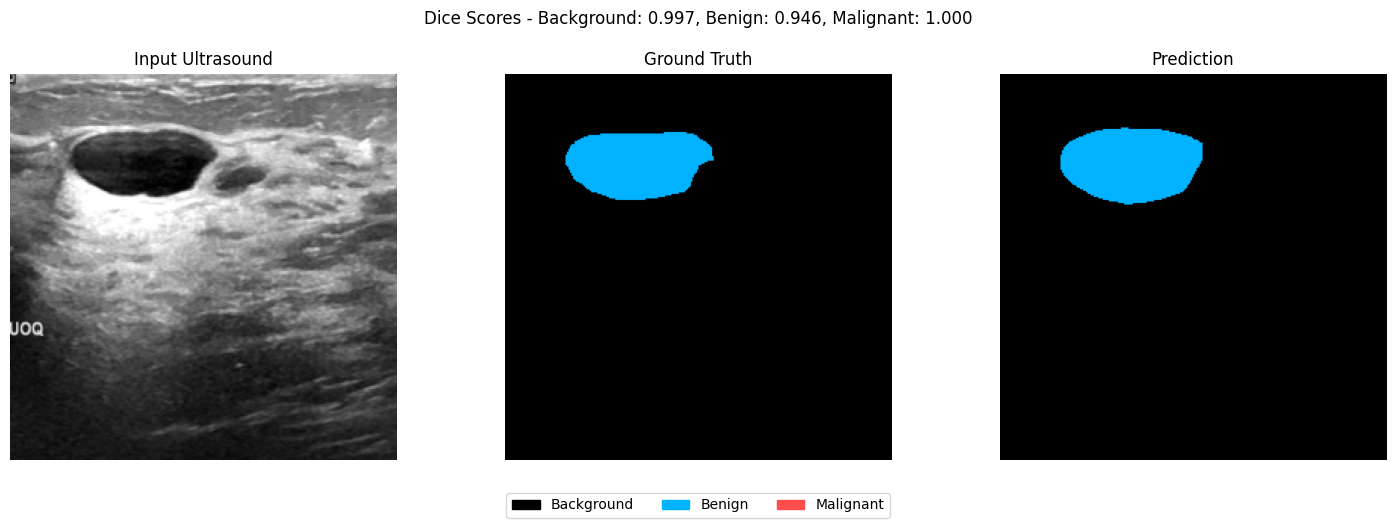

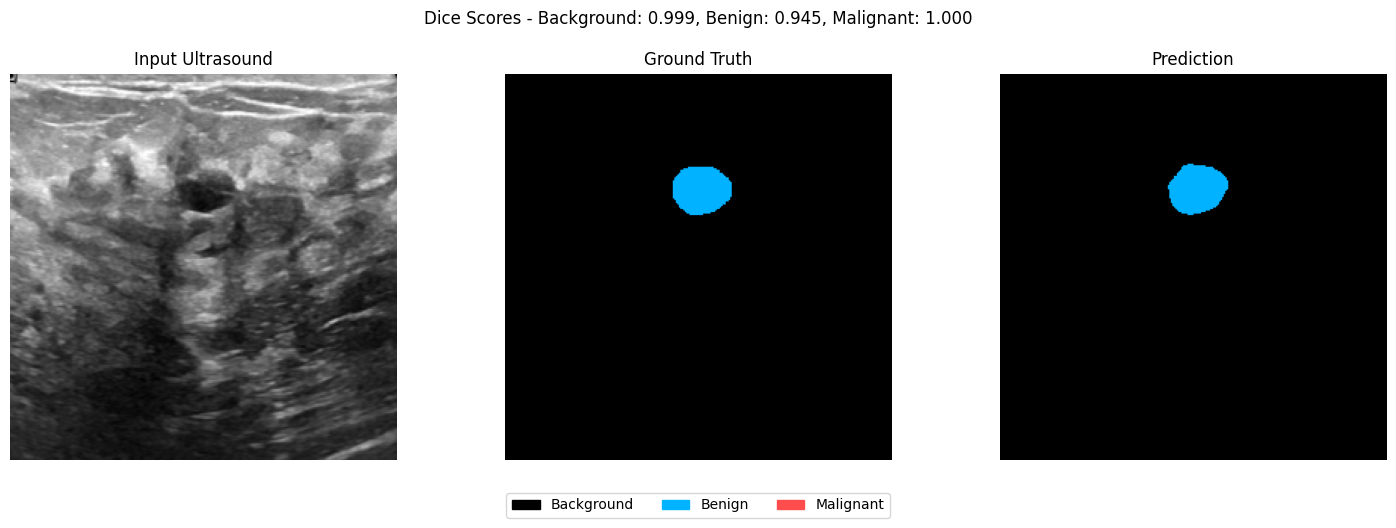

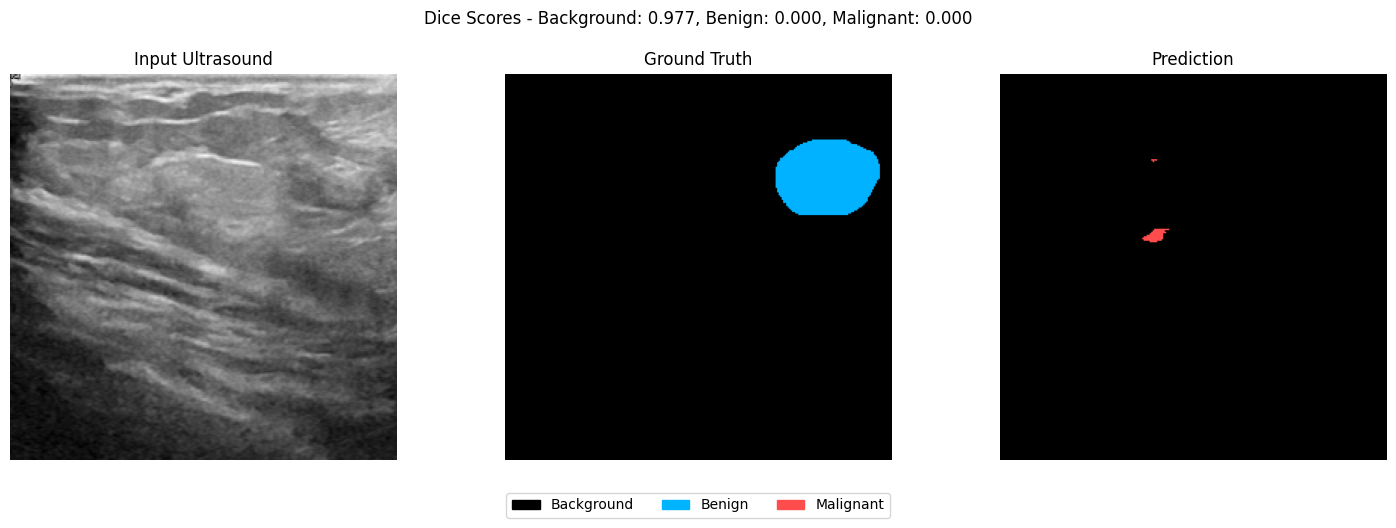

In [ ]:
visualize_multiclass_prediction(
    model, val_loader, num_samples=20
)

### Submission to Kaggle

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import cv2
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import glob

class BUSITestDataset(Dataset):
    """Dataset for BUSI test images."""
    def __init__(self, test_dir, image_size=(256, 256)):
        self.test_dir = test_dir
        self.image_size = image_size

        # Get all image files
        self.image_files = [f for f in os.listdir(test_dir)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))]
        self.image_files.sort()  # Sort for consistent order

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.test_dir, image_name)

        # Get image ID (filename without extension)
        image_id = os.path.splitext(image_name)[0]

        # Read image in original size
        original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        original_size = original_image.shape  # Store original size

        # Resize for model input
        image = cv2.resize(original_image, self.image_size, interpolation=cv2.INTER_AREA)

        # Normalize
        image = image.astype(np.float32) / 255.0

        # Convert to tensor
        image_tensor = torch.from_numpy(image).unsqueeze(0)  # Add channel dimension

        return {
            'image': image_tensor,
            'image_id': image_id,
            'original_h': original_size[0],  # Store original size for correct RLE encoding
            'original_w': original_size[1]
        }

def rle_encode_mask(mask):
    """Run-length encode a binary mask."""
    if np.sum(mask) == 0:
        return ''

    pixels = mask.flatten()
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs = np.concatenate([[0], runs])

    run_lengths = []
    for i in range(len(runs) - 1):
        if pixels[runs[i]] == 1:
            start = runs[i] + 1  # 1-indexed
            length = runs[i + 1] - runs[i]
            run_lengths.extend([start, length])

    return ' '.join(str(x) for x in run_lengths)

def combined_encode(masks_dict, delimiter="~"):
    """
    Encode multiple class masks into a single string.

    Args:
        masks_dict: Dictionary mapping class_id to binary mask
        delimiter: String to use as delimiter between class encodings

    Returns:
        Combined encoded string in format "class_id:rle~class_id:rle~..."
    """
    if not masks_dict:
        return ""

    encoded_parts = []

    for class_id, mask in masks_dict.items():
        rle = rle_encode_mask(mask)
        if rle:  # Only include non-empty masks
            encoded_parts.append(f"{class_id}:{rle}")

    return delimiter.join(encoded_parts)

def generate_submission(model, test_dir, output_file, batch_size=4, device=None, image_size=(256, 256)):
    """
    Generate a submission file from model predictions on test images.

    Args:
        model: Trained PyTorch model
        test_dir: Directory containing test images
        output_file: Path to save the submission CSV
        batch_size: Batch size for inference
        device: Device to run inference on
        image_size: Size to resize images to
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create test dataset and loader
    test_dataset = BUSITestDataset(test_dir, image_size=image_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Move model to device and set to evaluation mode
    model.to(device)
    model.eval()

    # Results dictionary
    results = {
        'ID': [],
        'encoded_pixels': []
    }

    # Process each batch
    print("Generating predictions...")
    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['image'].to(device)
            image_ids = batch['image_id']
            original_hs = batch['original_h']  # [B, 2] tensor with original H, W
            original_ws = batch['original_w']  # [B, 2] tensor with original H, W

            # Forward pass
            outputs = model(images)

            # Process predictions
            batch_size = images.shape[0]

            # For multi-class segmentation (assuming outputs have shape [B, C, H, W])
            is_multiclass = outputs.shape[1] > 1

            if is_multiclass:
                # Get class predictions for each pixel
                predictions = torch.argmax(outputs, dim=1).cpu().numpy()  # [B, H, W]

                for i in range(batch_size):
                    image_id = image_ids[i]
                    pred = predictions[i]  # [H, W]
                    orig_h, orig_w = original_hs[i].item(), original_ws[i].item()

                    # Resize prediction back to original image size before RLE encoding
                    # CRITICAL: Use nearest neighbor interpolation for masks
                    pred_resized = cv2.resize(
                        pred.astype(np.float32),
                        (orig_w, orig_h),
                        interpolation=cv2.INTER_NEAREST
                    ).astype(np.int32)

                    # Create mask dictionary for this image
                    masks_dict = {}
                    for class_id in range(1, outputs.shape[1]):
                        # Create binary mask for this class using the RESIZED prediction
                        binary_mask = (pred_resized == class_id).astype(np.uint8)

                        # Only add non-empty masks
                        if np.sum(binary_mask) > 0:
                            masks_dict[class_id] = binary_mask

                    # Encode masks (will return empty string if no masks)
                    encoded_pixels = combined_encode(masks_dict)

                    # Add to results (even if encoded_pixels is empty)
                    results['ID'].append(image_id)
                    results['encoded_pixels'].append(encoded_pixels)

            else:
                # Binary segmentation - apply sigmoid and threshold
                predictions = torch.sigmoid(outputs).cpu().numpy() > 0.5

                for i in range(batch_size):
                    image_id = image_ids[i]
                    pred = predictions[i, 0]  # [H, W]
                    orig_h, orig_w = original_sizes[i]

                    # Resize prediction back to original image size
                    pred_resized = cv2.resize(
                        pred.astype(np.float32),
                        (orig_w, orig_h),
                        interpolation=cv2.INTER_NEAREST
                    ).astype(np.uint8)

                    # Create mask dictionary for classes 1 and 2
                    masks_dict = {}
                    for class_id in [1, 2]:  # Both benign and malignant
                        binary_mask = pred_resized.astype(np.uint8)

                        # Only add non-empty masks
                        if np.sum(binary_mask) > 0:
                            masks_dict[class_id] = binary_mask

                    # Encode masks (will return empty string if no masks)
                    encoded_pixels = combined_encode(masks_dict)

                    # Add to results (even if encoded_pixels is empty)
                    results['ID'].append(image_id)
                    results['encoded_pixels'].append(encoded_pixels)

    # Create DataFrame
    submission_df = pd.DataFrame(results)

    # Make sure there are no NULL/None values - replace with empty strings
    submission_df['encoded_pixels'] = submission_df['encoded_pixels'].fillna('')
    submission_df.loc[submission_df['encoded_pixels'] == '', 'encoded_pixels'] = '<empty>'

    # Sort by image_id for consistency
    submission_df = submission_df.sort_values('ID')

    # Save to CSV
    submission_df.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")
    print(f"Total entries: {len(submission_df)}")
    print(f"Empty predictions: {(submission_df['encoded_pixels'] == '<empty>').sum()}")

    # Validate submission
    if submission_df.isnull().any().any():
        print("WARNING: Submission contains NULL values!")
    else:
        print("Validation passed: No NULL values in submission.")

    return submission_df

In [ ]:
generate_submission(
    model=model,
    test_dir='/content/content/kaggle_dataset_3/test',
    output_file='Improved_adv1.csv',
    batch_size=16,
    device=device
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Generating predictions...


100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

Submission saved to Improved_adv1.csv
Total entries: 156
Empty predictions: 26
Validation passed: No NULL values in submission.


ID                                     encoded_pixels
0    image_000  2:212796 2 212801 8 213474 2 213479 8 214130 4...
1    image_001  1:19721 3 19726 2 20276 3 20281 2 24712 13 252...
2    image_002  1:68675 3 69241 3 69785 38 70351 38 70908 51 7...
3    image_003  1:40819 14 41508 14 42181 43 42870 43 43559 43...
4    image_004  1:142978 9 143750 9 144513 33 145285 33 146051...
..         ...                                                ...
151  image_151  1:95004 2 95009 9 95760 2 95765 9 96495 38 972...
152  image_152  1:35890 18 36240 29 36595 35 36951 38 37308 38...
153  image_153  1:143904 51 144667 51 145422 65 146185 65 1469...
154  image_154  2:160926 10 161709 10 162456 52 163239 52 1640...
155  image_155  2:27234 11 27794 11 28347 29 28382 2 28386 3 2...

[156 rows x 2 columns]